In [18]:
import elfi
import numpy as np
import pylab as plt
import scipy.stats as ss
from scipy.stats import entropy
from scipy.integrate import quad
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('../..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

In [3]:
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"

In [4]:
def plot_for_report(
    list_of_sampler, 
    posterior=None, 
    posterior_mean = None,
    posterior_label = "reference posterior",
    legend_text=None,
    title_text=None, 
    xlabel=None, 
    ylabel=None, 
    savefig=False, 
    figname=None,
    no_spines = ["top", "bottom", "right", "left"],
    mark_means = True,
    calc_kl = False,
    plot_hist = False,
    **kw_hist
):
    """plot kde for each sampler and true posterior if available"""
    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 


    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)  
    
    # plot for report
    # You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
    # exception because of the number of lines being plotted on it.    
    # Common sizes: (10, 7.5) and (12, 9)    
    plt.figure(figsize=(10, 7.5)) 

    # Remove the plot frame lines. They are unnecessary chartjunk.    
    ax = plt.subplot(111)    
    for spine in no_spines:
        ax.spines[spine].set_visible(False)
        
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.tick_params(axis='both', which='major', pad=15)

    #plot ABC posterior
    #xx = np.linspace(mu_0 - 3*sigma_0, mu_0 + 4*sigma_0, 200)
    x_min = np.inf
    x_max = -np.inf
    for i, sampler in enumerate(list_of_sampler):
        thetas = sampler.Thetas.flatten()
        xx = np.linspace(np.min(thetas) - 0.1, np.max(thetas) + 0.1, 200)
        if x_min > np.min(xx):
            x_min = np.min(xx)
        if x_max < np.max(xx):
            x_max = np.max(xx)
            
        # plot posterior
        #plt.hist(thetas, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
        # plot KDE and MAP
        # get the bandwidth method argument for scipy
        # and run scipy's kde
        kde = ss.kde.gaussian_kde(thetas)
        dens = kde(xx)
        if legend_text is not None:
            plt.plot(xx, dens, color=tableau20[i*2], label=legend_text[i])
        else:
            plt.plot(xx, dens, color=tableau20[i*2])
        
        if plot_hist:
            plt.hist(thetas, normed=True, color=tableau20[i*2], **kw_hist)
        
        #mark means
        if mark_means:
            mean = np.mean(thetas)
            plt.plot(mean, 0, color=tableau20[i*2], marker="D")

    # plot ground truth posterior
    kl = []
    if posterior is not None:
        xx = np.linspace(x_min, x_max, 200)
        yy = posterior(xx)
        plt.plot(xx, yy, "m", label=posterior_label, linewidth=3, color="m")
        
        if mark_means:
            if posterior_mean is None:
                if mark_means:
                    mean, err = quad(lambda x : x * posterior(x), x_min-1, x_max+1)
                    print("posterior mean:", mean, "with error", err)
                    # find closest x
                    plt.plot(mean, 0, color="m", marker="D")
            else:
                plt.plot(posterior_mean, 0, color="m", marker="D")
                print("posterior mean:", posterior_mean)
            
        # calculate kullback leibler divergence
        if calc_kl:
            for i, sampler in enumerate(list_of_sampler):
                thetas = sampler.Thetas.flatten()
            
                # plot posterior
                #plt.hist(thetas, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
                # plot KDE and MAP
                # get the bandwidth method argument for scipy
                # and run scipy's kde
                kde = ss.kde.gaussian_kde(thetas)
                kl.append(
                    entropy(
                        np.where(kde(xx) < 1e-50, 1e-50, kde(xx)),
                        np.where(posterior(xx) < 1e-50, 1e-50, posterior(xx))
                    )
                )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(r"$\theta$")
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(r"$p(\theta|D)$")
    
    if title_text is not None:
        plt.title(title_text)
        
    plt.legend(fontsize=14)
    plt.gca().set_ylim(bottom=-0.1)
    
    if savefig:
        plt.savefig(figname, bbox_inches='tight')
        
    return kl

# The problem

We begin with a very intuitive and easy toy example that will allow us to analytically compute the posterior. Our model will be $x \sim \mathcal{N}(\mu,\sigma^2)$, that is $x$ is distributed according to a Gaussian normal distribution with mean $\mu$ and variance $\sigma^2$. Let us assume that we have observed data $D=\{x_i|i=1,\ldots,30\}$ for which we know the variance $\sigma^2=1$ (for example from previous experiments or from literature)

# Generative Model

For the purpose of different priors, we assume that our generative model has the following shape: $g: x \sim \mathcal{N}(0.5, 1)$

In [5]:
np.random.seed(1335)

In [6]:
mu_t, sigma_t = 0.5, 1
mu_0, sigma_0 = 0, 0.2

N = 10

In [7]:
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
#os.makedirs(os.path.basename(os.path.join("data", "D")), exist_ok=True)
#pickle.dump(D, open(os.path.join("data", "D.pkl"), "wb"))
np.atleast_2d(D)

array([[-0.55286363,  0.73839318, -0.05872936,  2.57544769,  0.33974323,
        -0.7431614 , -1.14733082, -0.39151276,  0.7952032 ,  0.48591288]])

<IPython.core.display.Javascript object>


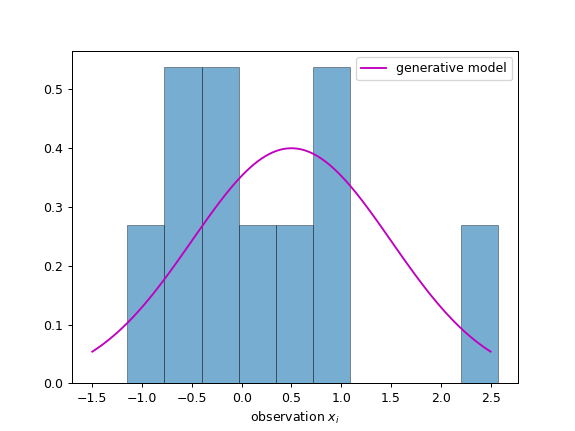

Text(0.5,0,'observation $x_i$')

In [8]:
plt.figure()
plt.hist(D, edgecolor="k", linewidth=0.5, color=["C0"], normed=True, alpha=0.6, histtype="bar", bins=N)
x = np.linspace(0.5-2, 0.5+2, 100)
y = ss.norm.pdf(x, mu_t, np.sqrt(sigma_t))
plt.plot(x,y, "-", color="m", label="generative model")
plt.legend()
plt.xlabel("observation $x_i$")

# Prior and Likelihood

We are interested in the probability distribution of the model parameter $\theta=\mu$ given our observed data, thus with Bayes' Theorem we can write

$p(\theta|D) \propto p(D|\theta) \cdot p(\theta).$

With the assumption of indentically and independently distributed (i.i.d.) drawn samples, the likelihood $p(D|\theta)$ can be written as the product of the likelihoods for each datum: $p(D|\theta) = \prod_{i=1}^N p(x_i|\theta) = (\cfrac{1}{2\pi\sigma²})^{\frac{n}{2}} \exp \left( -\cfrac{\sum_i^n (x_i - \mu)^2}{2\sigma^2} \right)$.

The prior represents our initial belief about the values $\theta=\mu$ might take. We will analyse the following three priors that represent very different initial belief sets.

$p(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0)$, with $\mu_0 = 0, \sigma_0^2 = 0.2$

<IPython.core.display.Javascript object>


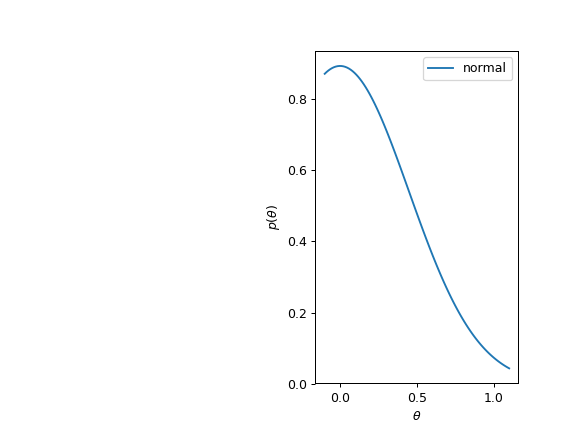

In [9]:
plt.figure()

# normal distributed prior
plt.subplot(1,2,2)
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
plt.plot(x,y, label="normal")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# Posterior

Now we look at the posterior. For each of the three priors, we can analytically calculate the posterior. Lets do this:

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
\end{align}
$

In [11]:
def likelihood(mus):
    ret = np.zeros(mus.shape[0])
    for i, mu in enumerate(mus):
        ret[i] = ss.norm(mu, sigma_t / N).pdf(np.mean(D))
    return ret

def posterior(mus):
    mus = np.atleast_1d(mus)
    
    sigma_N = 1 / (N/sigma_t + 1/sigma_0)
    mu_N = sigma_N * (mu_0 / sigma_0 + N * np.mean(D) / sigma_t)
    
    ret = np.zeros(mus.shape[0])
    for i, mu in enumerate(mus):
        ret[i] = ss.norm(mu_N, np.sqrt(sigma_N)).pdf(mu)
    return ret

In [12]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 


# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

<IPython.core.display.Javascript object>


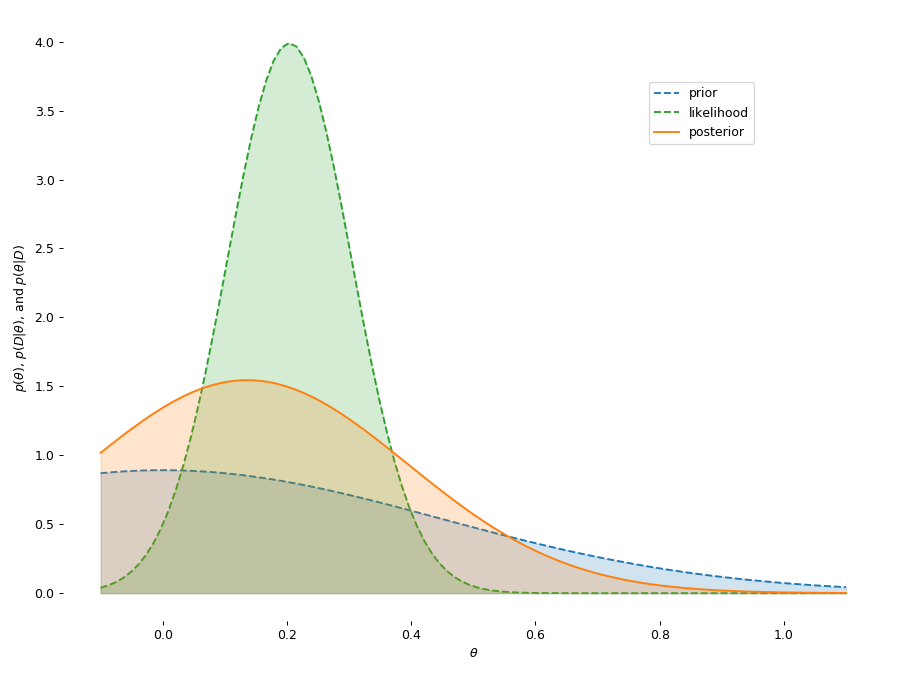

In [13]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(10, 7.5)) 

# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
#plt.yticks(np.arange(0, 4.5, 0.5), [str(x) for x in np.arange(0, 4.5, 0.5)])    
#plt.xticks(fontsize=12) 
thetas = np.linspace(-0.1, 1.1, 100)
prior = ss.norm.pdf(thetas, mu_0, np.sqrt(sigma_0))
ax.fill_between(thetas, y1=y, y2=0, alpha=0.2, zorder=0, color=tableau20[0])
ax.plot(thetas,y, "--", label="prior",  color=tableau20[0], zorder=0)

#ax2 = ax.twinx()
like = likelihood(thetas)
ax.fill_between(thetas, y1=like, y2=0, alpha=0.2,  color=tableau20[4], zorder=1)
ax.plot(thetas, like, "--", label="likelihood",  color=tableau20[4], zorder=1)

ax.fill_between(thetas, y1=posterior(thetas), y2=0, alpha=0.2,  color=tableau20[2], zorder=30)
ax.plot(thetas, posterior(thetas), label="posterior",  color=tableau20[2], zorder=30)

plt.xlabel(r"$\theta$")
ax.set_ylabel(r"$p(\theta)$, $p(D|\theta)$, and $p(\theta|D)$")

plt.legend(bbox_to_anchor=(0.85, 0.9))
plt.tight_layout()

plt.savefig('ex01_model.pdf', bbox_inches='tight')

# ABC

In [181]:
prior = pyabc.Prior("normal", mu_0, np.sqrt(sigma_0), name=r"$\mu$")

In [22]:
def simulator_mu(mu, batch_size=1, random_state=None):
    return ss.norm(loc=mu, scale=np.sqrt(sigma_t)).rvs((batch_size, N))

simulator_mu(0)

array([[-1.36402709, -0.79474783, -1.07291723,  0.21274463, -0.58600603,
        -0.97971222,  1.18346127,  0.22661906,  0.48866767, -0.03059361]])

In [23]:
def mean(x):
    return np.mean(np.atleast_2d(x), axis=1)

## Show correctness for three classical ABC sampler

In [14]:
D = np.atleast_2d(D)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)
mcmc = pyabc.MCMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)
smc = pyabc.SMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)

In [24]:
# or load data
rej = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_2000_0_02.pkl"))
mcmc = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "mcmc_2000_0_02_0_1.pkl"))

In [33]:
rej.sample(nr_samples=2000, threshold=0.02)

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:     29 /   2000 (  1 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 0.029000 - Time:     0.76 s
Samples:     55 /   2000 (  3 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 0.027500 - Time:     1.46 s
Samples:     88 /   2000 (  4 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.029333 - Time:     2.14 s
Samples:    119 /   2000 (  6 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.029750 - Time:     2.82 s
Samples:    148 /   2000 (  7 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.029600 - Time:     3.54 s
Samples:    173 /   2000 (  9 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.028833 - Time:     4.22 s
Samples:    198 /   2000 ( 10 %)- Threshold: 0.0200 - Iterations:       7000 - Acceptance rate: 0.028286 - Time:     4.90 s
Samples:    229 /   2000 ( 11 %)- Threshold: 0.0200 - Ite

Samples:   1841 /   2000 ( 92 %)- Threshold: 0.0200 - Iterations:      67000 - Acceptance rate: 0.027478 - Time:    49.76 s
Samples:   1871 /   2000 ( 94 %)- Threshold: 0.0200 - Iterations:      68000 - Acceptance rate: 0.027515 - Time:    50.55 s
Samples:   1895 /   2000 ( 95 %)- Threshold: 0.0200 - Iterations:      69000 - Acceptance rate: 0.027464 - Time:    51.28 s
Samples:   1916 /   2000 ( 96 %)- Threshold: 0.0200 - Iterations:      70000 - Acceptance rate: 0.027371 - Time:    52.03 s
Samples:   1949 /   2000 ( 97 %)- Threshold: 0.0200 - Iterations:      71000 - Acceptance rate: 0.027451 - Time:    52.72 s
Samples:   1977 /   2000 ( 99 %)- Threshold: 0.0200 - Iterations:      72000 - Acceptance rate: 0.027458 - Time:    53.40 s
Samples:   1999 /   2000 (100 %)- Threshold: 0.0200 - Iterations:      73000 - Acceptance rate: 0.027384 - Time:    54.07 s
Samples:   2033 /   2000 (102 %)- Threshold: 0.0200 - Iterations:      74000 - Acceptance rate: 0.027473 - Time:    54.73 s
Samples:

In [35]:
rej.save(os.path.join(path_to_data, "ex01", "rej_2000_0_02.pkl"))

In [36]:
mcmc.sample(nr_samples=2000, threshold=0.02, step_size=[0.1])

MCMC sampler started with threshold: 0.02 and number of samples: 2000
Samples:     10 - Threshold: 0.0200 - Iterations:        180 - Acceptance rate: 0.055556 - Time:     0.21 s
Samples:     46 /   2000 (  2 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 2.000000 - Time:     1.20 s
Samples:     64 /   2000 (  3 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 1.000000 - Time:     2.15 s
Samples:     89 /   2000 (  4 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.666667 - Time:     3.10 s
Samples:    119 /   2000 (  6 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.500000 - Time:     4.06 s
Samples:    149 /   2000 (  7 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.400000 - Time:     5.04 s
Samples:    174 /   2000 (  9 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.333333 - Time:     6.04 s
Samples:    208 /   2000 ( 10 %)- Threshold: 0.0200 - Iterations:       7000 -

In [37]:
mcmc.save(os.path.join(path_to_data, "ex01", "mcmc_2000_0_02_0_1.pkl"))

In [16]:
smc.sample(nr_samples=2000, thresholds=np.linspace(0.1, 0.02, 6))

SMC sampler started with thresholds: [ 0.1    0.084  0.068  0.052  0.036  0.02 ] and number of samples: 2000
Rejection sampler started with threshold: 0.1 and number of samples: 2000
Samples:    143 /   2000 (  7 %)- Threshold: 0.1000 - Iterations:       1000 - Acceptance rate: 0.143000 - Time:     0.77 s
Samples:    268 /   2000 ( 13 %)- Threshold: 0.1000 - Iterations:       2000 - Acceptance rate: 0.134000 - Time:     1.48 s
Samples:    424 /   2000 ( 21 %)- Threshold: 0.1000 - Iterations:       3000 - Acceptance rate: 0.141333 - Time:     2.18 s
Samples:    562 /   2000 ( 28 %)- Threshold: 0.1000 - Iterations:       4000 - Acceptance rate: 0.140500 - Time:     3.05 s
Samples:    680 /   2000 ( 34 %)- Threshold: 0.1000 - Iterations:       5000 - Acceptance rate: 0.136000 - Time:     3.78 s
Samples:    802 /   2000 ( 40 %)- Threshold: 0.1000 - Iterations:       6000 - Acceptance rate: 0.133667 - Time:     4.44 s
Samples:    917 /   2000 ( 46 %)- Threshold: 0.1000 - Iterations:       7

Samples:   1140 /   2000 ( 57 %)- Threshold: 0.0520 - Iterations:      69000 - Acceptance rate: 0.028986 - Time:    87.89 s
Samples:   1220 /   2000 ( 61 %)- Threshold: 0.0520 - Iterations:      70000 - Acceptance rate: 0.028571 - Time:    89.37 s
Samples:   1285 /   2000 ( 64 %)- Threshold: 0.0520 - Iterations:      71000 - Acceptance rate: 0.028169 - Time:    91.35 s
Samples:   1504 /   2000 ( 75 %)- Threshold: 0.0520 - Iterations:      74000 - Acceptance rate: 0.027027 - Time:    95.94 s
Samples:   1643 /   2000 ( 82 %)- Threshold: 0.0520 - Iterations:      76000 - Acceptance rate: 0.026316 - Time:    98.66 s
Samples:   1725 /   2000 ( 86 %)- Threshold: 0.0520 - Iterations:      77000 - Acceptance rate: 0.025974 - Time:    99.90 s
Samples:   1802 /   2000 ( 90 %)- Threshold: 0.0520 - Iterations:      78000 - Acceptance rate: 0.025641 - Time:   101.12 s
Samples:   1878 /   2000 ( 94 %)- Threshold: 0.0520 - Iterations:      79000 - Acceptance rate: 0.025316 - Time:   102.38 s
Samples:

Samples:    610 /   2000 ( 30 %)- Threshold: 0.0200 - Iterations:     141000 - Acceptance rate: 0.014184 - Time:   181.93 s
Samples:    643 /   2000 ( 32 %)- Threshold: 0.0200 - Iterations:     142000 - Acceptance rate: 0.014085 - Time:   183.14 s
Samples:    663 /   2000 ( 33 %)- Threshold: 0.0200 - Iterations:     143000 - Acceptance rate: 0.013986 - Time:   184.35 s
Samples:    696 /   2000 ( 35 %)- Threshold: 0.0200 - Iterations:     144000 - Acceptance rate: 0.013889 - Time:   185.56 s
Samples:    719 /   2000 ( 36 %)- Threshold: 0.0200 - Iterations:     145000 - Acceptance rate: 0.013793 - Time:   186.80 s
Samples:    747 /   2000 ( 37 %)- Threshold: 0.0200 - Iterations:     146000 - Acceptance rate: 0.013699 - Time:   188.14 s
Samples:    781 /   2000 ( 39 %)- Threshold: 0.0200 - Iterations:     147000 - Acceptance rate: 0.013605 - Time:   189.45 s
Samples:    815 /   2000 ( 41 %)- Threshold: 0.0200 - Iterations:     148000 - Acceptance rate: 0.013514 - Time:   190.70 s
Samples:

In [17]:
smc.save(os.path.join(path_to_data, "ex01", "smc_2000_0_1_to_0_02.pkl"))

<IPython.core.display.Javascript object>


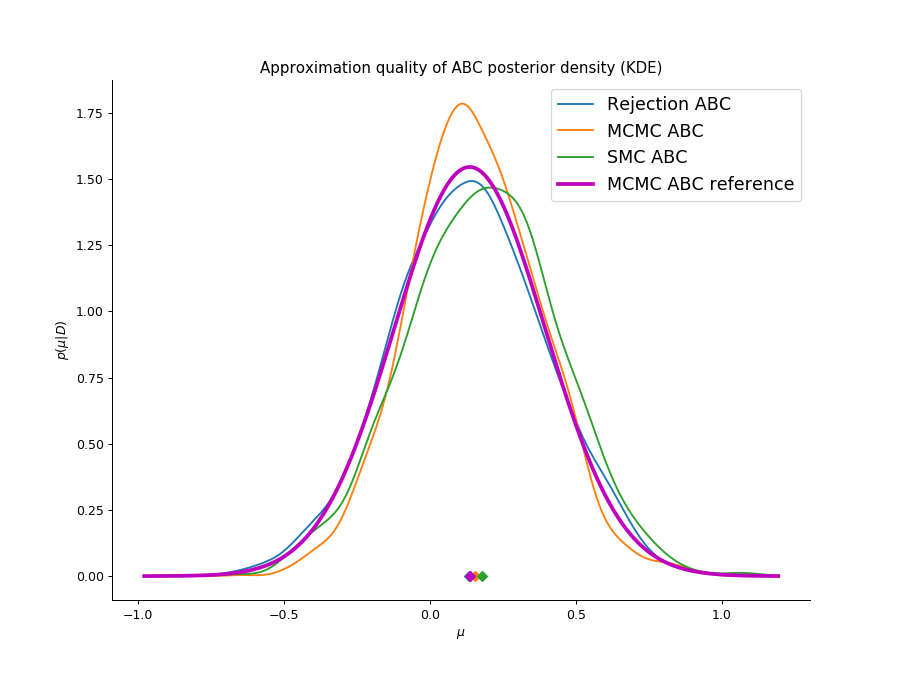

posterior mean: 0.13607348005542946 with error 1.2298344706022925e-11


[0.0027870286324237041, 0.018088042324292557, 0.018054802675491505]

In [19]:
rej = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_2000_0_02.pkl"))
mcmc = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "mcmc_2000_0_02_0_1.pkl"))
smc = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "smc_2000_0_1_to_0_02.pkl"))

legend = ["Rejection ABC", "MCMC ABC", "SMC ABC"]
plot_for_report(
    list_of_sampler = [rej, mcmc, smc], 
    posterior=posterior, 
    legend_text=legend, 
    title_text="Approximation quality of ABC posterior density (KDE)", 
    xlabel=r"$\mu$", 
    ylabel=r"$p(\mu|D)$",
    savefig=True,
    figname="ex01_3_abc_methods.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True
)

In [194]:
abs(x_mean - rej.Thetas.mean())

0.0021784523927698418

In [195]:
abs(x_mean - mcmc.Thetas.mean())

0.016761799821675027

In [196]:
abs(x_mean - smc.Thetas.mean())

0.043977752841931339

# Comparison with ELFI

In [ ]:
mu = elfi.Prior('normal', mu_0, np.sqrt(sigma_0))

# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator_mu, mu, observed=np.atleast_2d(D))

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
d = elfi.Distance('euclidean', S1)

In [ ]:
# Plot the complete model (requires graphviz)
elfi.draw(d)

In [ ]:
elfi_smc = elfi.SMC(d, batch_size=1, seed=30052017)
elfi_smc = smc.sample(2000, np.linspace(0.1,0.03,4))

elfi_smc.summary()

In [ ]:
elfi_smc.plot_marginals()

## Analyze influence of parameter

### Influence of epsilon

In [59]:
rej.sample(nr_samples=2000, threshold=1)
rej.save(os.path.join(path_to_data, "ex01", "rej_2000_1.pkl"))

rej.sample(nr_samples=2000, threshold=0.5)
rej.save(os.path.join(path_to_data, "ex01", "rej_2000_0_5.pkl"))


Rejection sampler started with threshold: 1 and number of samples: 2000
Samples:    908 /   2000 ( 45 %)- Threshold: 1.0000 - Iterations:       1000 - Acceptance rate: 0.908000 - Time:     0.74 s
Samples:   1813 /   2000 ( 91 %)- Threshold: 1.0000 - Iterations:       2000 - Acceptance rate: 0.906500 - Time:     1.44 s
Samples:   2732 /   2000 (137 %)- Threshold: 1.0000 - Iterations:       3000 - Acceptance rate: 0.910667 - Time:     2.14 s
Samples:   2000 - Threshold: 1.0000 - Iterations:       3000 - Acceptance rate: 0.666667 - Time:     2.14 s
Rejection sampler started with threshold: 0.5 and number of samples: 2000
Samples:    608 /   2000 ( 30 %)- Threshold: 0.5000 - Iterations:       1000 - Acceptance rate: 0.608000 - Time:     0.78 s
Samples:   1191 /   2000 ( 60 %)- Threshold: 0.5000 - Iterations:       2000 - Acceptance rate: 0.595500 - Time:     1.49 s
Samples:   1771 /   2000 ( 89 %)- Threshold: 0.5000 - Iterations:       3000 - Acceptance rate: 0.590333 - Time:     2.21 s
Sa

<IPython.core.display.Javascript object>


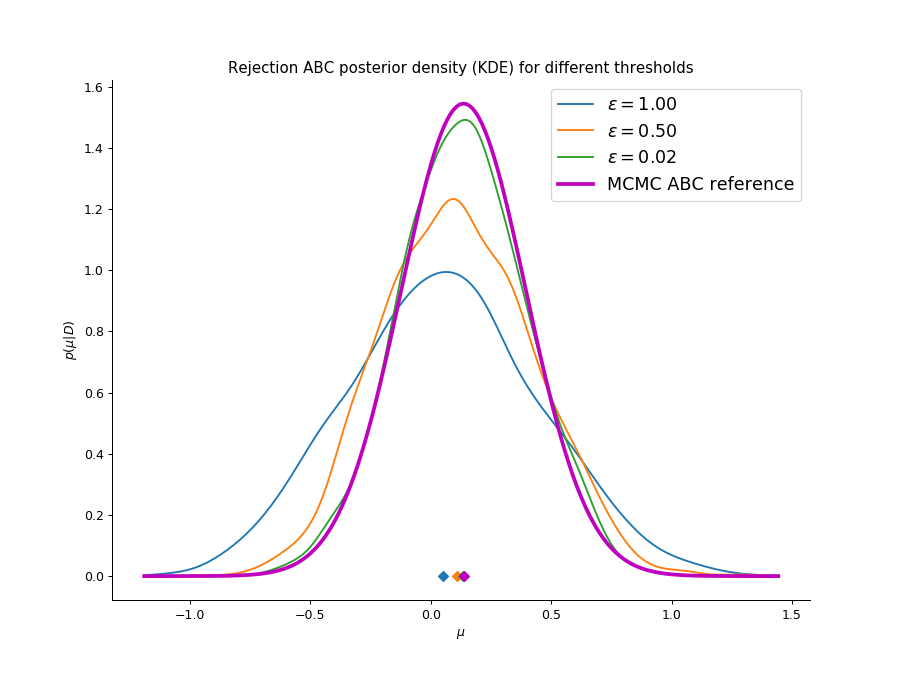

posterior mean: 0.136073480055431 with error 8.040709760612653e-11


[0.34031673307033222, 0.060957894101819572, 0.0028116209415341049]

In [21]:
rej_1 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_2000_1.pkl"))
rej_2 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_2000_0_5.pkl"))
rej_3 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_2000_0_02.pkl"))

legend = [r"$\epsilon=1.00$", r"$\epsilon=0.50$", r"$\epsilon=0.02$"]
plot_for_report(
    list_of_sampler=[rej_1, rej_2, rej_3], 
    posterior=posterior, 
    legend_text=legend, 
    title_text="Rejection ABC posterior density (KDE) for different thresholds", 
    xlabel=r"$\mu$", 
    ylabel=r"$p(\mu|D)$",
    savefig=True,
    figname="ex01_rej_with_diff_thresholds.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True
)


In [199]:
abs(x_mean - rej_1.Thetas.mean())

0.085429878839561602

In [200]:
abs(x_mean - rej_2.Thetas.mean())

0.026836729773712334

In [201]:
abs(x_mean - rej_3.Thetas.mean())

0.0021784523927698418

In [13]:
import pandas as pd
df = pd.DataFrame({'threshold': [1, 0.5, 0.02], 'iterations': [3000, 4000, 74000], 'KL': [25.7, 4.6057, 0.2573]})

<IPython.core.display.Javascript object>


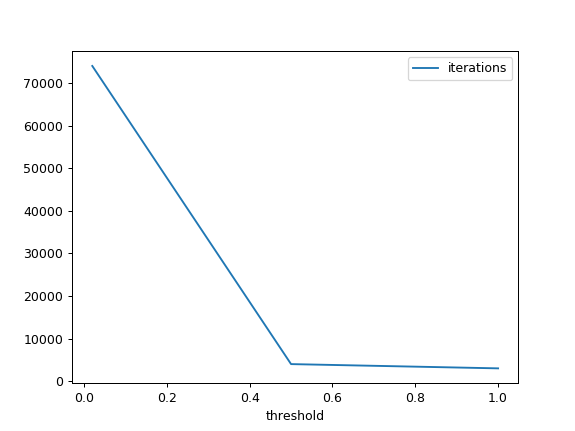

<IPython.core.display.Javascript object>


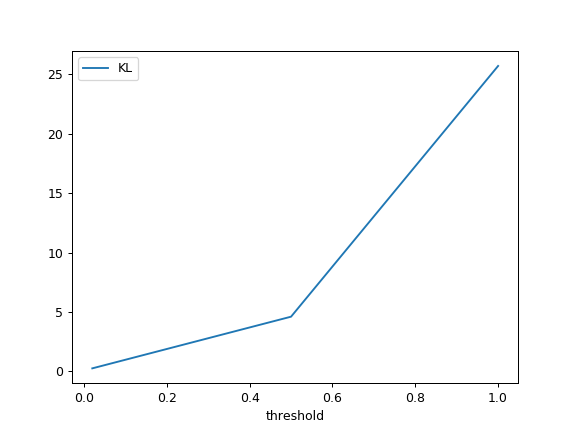

In [18]:
df.plot(x='threshold', y='iterations')
df.plot(x='threshold', y='KL')

### Influence of samples

In [25]:
np.random.seed(1337)

N = 100
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)

In [26]:
from scipy.integrate import quad
x_mean = quad(lambda x : x * posterior(x), -2, 2)[0]
x_mean

0.3289307819792878

In [17]:
# full data set
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)
rej.sample(nr_samples=200, threshold=0.02)

rej.save(os.path.join(path_to_data, "ex01", "rej_200_0_02_N_100.pkl"))

Rejection sampler started with threshold: 0.02 and number of samples: 200
Samples:     25 /    200 ( 12 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 0.025000 - Time:     0.64 s
Samples:     59 /    200 ( 30 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 0.029500 - Time:     1.26 s
Samples:     88 /    200 ( 44 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.029333 - Time:     1.89 s
Samples:    117 /    200 ( 58 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.029250 - Time:     2.50 s
Samples:    146 /    200 ( 73 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.029200 - Time:     3.12 s
Samples:    175 /    200 ( 88 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.029167 - Time:     3.74 s
Samples:    194 /    200 ( 97 %)- Threshold: 0.0200 - Iterations:       7000 - Acceptance rate: 0.027714 - Time:     4.36 s
Samples:    214 /    200 (107 %)- Threshold: 0.0200 - Iter

In [42]:
# only 10
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D[:10], verbosity=2)
rej.sample(nr_samples=2000, threshold=0.02)

rej.save(os.path.join(path_to_data, "ex01", "rej_2000_0_02_N_10.pkl"))

# only 50
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D[:N//2], verbosity=2)
rej.sample(nr_samples=2000, threshold=0.02)

rej.save(os.path.join(path_to_data, "ex01", "rej_2000_0_02_N_50.pkl"))

# full data set
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)
rej.sample(nr_samples=2000, threshold=0.02)

rej.save(os.path.join(path_to_data, "ex01", "rej_2000_0_02_N_100.pkl"))

rej.sample(nr_samples=5000, threshold=0.02)

rej.save(os.path.join(path_to_data, "ex01", "rej_5000_0_02_N_100.pkl"))

rej.sample(nr_samples=10000, threshold=0.02)

rej.save(os.path.join(path_to_data, "ex01", "rej_10000_0_02_N_100.pkl"))


Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:     35 /   2000 (  2 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 0.035000 - Time:     0.67 s
Samples:     74 /   2000 (  4 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 0.037000 - Time:     1.35 s
Samples:     96 /   2000 (  5 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.032000 - Time:     2.00 s
Samples:    138 /   2000 (  7 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.034500 - Time:     2.67 s
Samples:    171 /   2000 (  9 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.034200 - Time:     3.32 s
Samples:    212 /   2000 ( 11 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.035333 - Time:     3.97 s
Samples:    241 /   2000 ( 12 %)- Threshold: 0.0200 - Iterations:       7000 - Acceptance rate: 0.034429 - Time:     4.68 s
Samples:    279 /   2000 ( 14 %)- Threshold: 0.0200 - Ite

Samples:    109 /   2000 (  5 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.021800 - Time:     3.63 s
Samples:    140 /   2000 (  7 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.023333 - Time:     4.48 s
Samples:    165 /   2000 (  8 %)- Threshold: 0.0200 - Iterations:       7000 - Acceptance rate: 0.023571 - Time:     5.19 s
Samples:    197 /   2000 ( 10 %)- Threshold: 0.0200 - Iterations:       8000 - Acceptance rate: 0.024625 - Time:     5.87 s
Samples:    231 /   2000 ( 12 %)- Threshold: 0.0200 - Iterations:       9000 - Acceptance rate: 0.025667 - Time:     6.53 s
Samples:    251 /   2000 ( 13 %)- Threshold: 0.0200 - Iterations:      10000 - Acceptance rate: 0.025100 - Time:     7.22 s
Samples:    267 /   2000 ( 13 %)- Threshold: 0.0200 - Iterations:      11000 - Acceptance rate: 0.024273 - Time:     7.90 s
Samples:    288 /   2000 ( 14 %)- Threshold: 0.0200 - Iterations:      12000 - Acceptance rate: 0.024000 - Time:     8.58 s
Samples:

Samples:   1762 /   2000 ( 88 %)- Threshold: 0.0200 - Iterations:      72000 - Acceptance rate: 0.024472 - Time:    53.91 s
Samples:   1787 /   2000 ( 89 %)- Threshold: 0.0200 - Iterations:      73000 - Acceptance rate: 0.024479 - Time:    54.55 s
Samples:   1812 /   2000 ( 91 %)- Threshold: 0.0200 - Iterations:      74000 - Acceptance rate: 0.024486 - Time:    55.20 s
Samples:   1821 /   2000 ( 91 %)- Threshold: 0.0200 - Iterations:      75000 - Acceptance rate: 0.024280 - Time:    55.89 s
Samples:   1845 /   2000 ( 92 %)- Threshold: 0.0200 - Iterations:      76000 - Acceptance rate: 0.024276 - Time:    56.54 s
Samples:   1872 /   2000 ( 94 %)- Threshold: 0.0200 - Iterations:      77000 - Acceptance rate: 0.024312 - Time:    57.21 s
Samples:   1891 /   2000 ( 95 %)- Threshold: 0.0200 - Iterations:      78000 - Acceptance rate: 0.024244 - Time:    57.87 s
Samples:   1915 /   2000 ( 96 %)- Threshold: 0.0200 - Iterations:      79000 - Acceptance rate: 0.024241 - Time:    58.54 s
Samples:

Samples:   1390 /   2000 ( 70 %)- Threshold: 0.0200 - Iterations:      54000 - Acceptance rate: 0.025741 - Time:    38.66 s
Samples:   1406 /   2000 ( 70 %)- Threshold: 0.0200 - Iterations:      55000 - Acceptance rate: 0.025564 - Time:    39.90 s
Samples:   1429 /   2000 ( 71 %)- Threshold: 0.0200 - Iterations:      56000 - Acceptance rate: 0.025518 - Time:    40.61 s
Samples:   1465 /   2000 ( 73 %)- Threshold: 0.0200 - Iterations:      57000 - Acceptance rate: 0.025702 - Time:    41.27 s
Samples:   1494 /   2000 ( 75 %)- Threshold: 0.0200 - Iterations:      58000 - Acceptance rate: 0.025759 - Time:    41.94 s
Samples:   1514 /   2000 ( 76 %)- Threshold: 0.0200 - Iterations:      59000 - Acceptance rate: 0.025661 - Time:    42.58 s
Samples:   1539 /   2000 ( 77 %)- Threshold: 0.0200 - Iterations:      60000 - Acceptance rate: 0.025650 - Time:    43.22 s
Samples:   1570 /   2000 ( 78 %)- Threshold: 0.0200 - Iterations:      61000 - Acceptance rate: 0.025738 - Time:    43.91 s
Samples:

Samples:   1066 /   5000 ( 21 %)- Threshold: 0.0200 - Iterations:      40000 - Acceptance rate: 0.026650 - Time:    39.49 s
Samples:   1096 /   5000 ( 22 %)- Threshold: 0.0200 - Iterations:      41000 - Acceptance rate: 0.026732 - Time:    40.36 s
Samples:   1123 /   5000 ( 22 %)- Threshold: 0.0200 - Iterations:      42000 - Acceptance rate: 0.026738 - Time:    41.22 s
Samples:   1152 /   5000 ( 23 %)- Threshold: 0.0200 - Iterations:      43000 - Acceptance rate: 0.026791 - Time:    42.04 s
Samples:   1175 /   5000 ( 24 %)- Threshold: 0.0200 - Iterations:      44000 - Acceptance rate: 0.026705 - Time:    42.87 s
Samples:   1197 /   5000 ( 24 %)- Threshold: 0.0200 - Iterations:      45000 - Acceptance rate: 0.026600 - Time:    43.86 s
Samples:   1225 /   5000 ( 24 %)- Threshold: 0.0200 - Iterations:      46000 - Acceptance rate: 0.026630 - Time:    44.62 s
Samples:   1243 /   5000 ( 25 %)- Threshold: 0.0200 - Iterations:      47000 - Acceptance rate: 0.026447 - Time:    45.34 s
Samples:

Samples:   2846 /   5000 ( 57 %)- Threshold: 0.0200 - Iterations:     107000 - Acceptance rate: 0.026598 - Time:    87.42 s
Samples:   2868 /   5000 ( 57 %)- Threshold: 0.0200 - Iterations:     108000 - Acceptance rate: 0.026556 - Time:    88.07 s
Samples:   2898 /   5000 ( 58 %)- Threshold: 0.0200 - Iterations:     109000 - Acceptance rate: 0.026587 - Time:    88.74 s
Samples:   2910 /   5000 ( 58 %)- Threshold: 0.0200 - Iterations:     110000 - Acceptance rate: 0.026455 - Time:    89.39 s
Samples:   2939 /   5000 ( 59 %)- Threshold: 0.0200 - Iterations:     111000 - Acceptance rate: 0.026477 - Time:    90.05 s
Samples:   2968 /   5000 ( 59 %)- Threshold: 0.0200 - Iterations:     112000 - Acceptance rate: 0.026500 - Time:    90.86 s
Samples:   3000 /   5000 ( 60 %)- Threshold: 0.0200 - Iterations:     113000 - Acceptance rate: 0.026549 - Time:    91.65 s
Samples:   3023 /   5000 ( 60 %)- Threshold: 0.0200 - Iterations:     114000 - Acceptance rate: 0.026518 - Time:    92.29 s
Samples:

Samples:   4653 /   5000 ( 93 %)- Threshold: 0.0200 - Iterations:     174000 - Acceptance rate: 0.026741 - Time:   131.48 s
Samples:   4684 /   5000 ( 94 %)- Threshold: 0.0200 - Iterations:     175000 - Acceptance rate: 0.026766 - Time:   132.11 s
Samples:   4706 /   5000 ( 94 %)- Threshold: 0.0200 - Iterations:     176000 - Acceptance rate: 0.026739 - Time:   132.74 s
Samples:   4744 /   5000 ( 95 %)- Threshold: 0.0200 - Iterations:     177000 - Acceptance rate: 0.026802 - Time:   133.37 s
Samples:   4769 /   5000 ( 95 %)- Threshold: 0.0200 - Iterations:     178000 - Acceptance rate: 0.026792 - Time:   134.00 s
Samples:   4790 /   5000 ( 96 %)- Threshold: 0.0200 - Iterations:     179000 - Acceptance rate: 0.026760 - Time:   134.63 s
Samples:   4817 /   5000 ( 96 %)- Threshold: 0.0200 - Iterations:     180000 - Acceptance rate: 0.026761 - Time:   135.26 s
Samples:   4843 /   5000 ( 97 %)- Threshold: 0.0200 - Iterations:     181000 - Acceptance rate: 0.026757 - Time:   135.89 s
Samples:

Samples:   1351 /  10000 ( 14 %)- Threshold: 0.0200 - Iterations:      51000 - Acceptance rate: 0.026490 - Time:    33.56 s
Samples:   1374 /  10000 ( 14 %)- Threshold: 0.0200 - Iterations:      52000 - Acceptance rate: 0.026423 - Time:    34.19 s
Samples:   1402 /  10000 ( 14 %)- Threshold: 0.0200 - Iterations:      53000 - Acceptance rate: 0.026453 - Time:    34.82 s
Samples:   1431 /  10000 ( 14 %)- Threshold: 0.0200 - Iterations:      54000 - Acceptance rate: 0.026500 - Time:    35.45 s
Samples:   1451 /  10000 ( 15 %)- Threshold: 0.0200 - Iterations:      55000 - Acceptance rate: 0.026382 - Time:    36.07 s
Samples:   1473 /  10000 ( 15 %)- Threshold: 0.0200 - Iterations:      56000 - Acceptance rate: 0.026304 - Time:    36.70 s
Samples:   1496 /  10000 ( 15 %)- Threshold: 0.0200 - Iterations:      57000 - Acceptance rate: 0.026246 - Time:    37.33 s
Samples:   1514 /  10000 ( 15 %)- Threshold: 0.0200 - Iterations:      58000 - Acceptance rate: 0.026103 - Time:    37.99 s
Samples:

Samples:   3060 /  10000 ( 31 %)- Threshold: 0.0200 - Iterations:     118000 - Acceptance rate: 0.025932 - Time:    90.19 s
Samples:   3088 /  10000 ( 31 %)- Threshold: 0.0200 - Iterations:     119000 - Acceptance rate: 0.025950 - Time:    91.50 s
Samples:   3114 /  10000 ( 31 %)- Threshold: 0.0200 - Iterations:     120000 - Acceptance rate: 0.025950 - Time:    92.45 s
Samples:   3133 /  10000 ( 31 %)- Threshold: 0.0200 - Iterations:     121000 - Acceptance rate: 0.025893 - Time:    93.41 s
Samples:   3159 /  10000 ( 32 %)- Threshold: 0.0200 - Iterations:     122000 - Acceptance rate: 0.025893 - Time:    94.34 s
Samples:   3194 /  10000 ( 32 %)- Threshold: 0.0200 - Iterations:     123000 - Acceptance rate: 0.025967 - Time:    95.36 s
Samples:   3220 /  10000 ( 32 %)- Threshold: 0.0200 - Iterations:     124000 - Acceptance rate: 0.025968 - Time:    96.42 s
Samples:   3246 /  10000 ( 32 %)- Threshold: 0.0200 - Iterations:     125000 - Acceptance rate: 0.025968 - Time:    97.36 s
Samples:

Samples:   4891 /  10000 ( 49 %)- Threshold: 0.0200 - Iterations:     185000 - Acceptance rate: 0.026438 - Time:   144.60 s
Samples:   4916 /  10000 ( 49 %)- Threshold: 0.0200 - Iterations:     186000 - Acceptance rate: 0.026430 - Time:   145.40 s
Samples:   4936 /  10000 ( 49 %)- Threshold: 0.0200 - Iterations:     187000 - Acceptance rate: 0.026396 - Time:   146.13 s
Samples:   4955 /  10000 ( 50 %)- Threshold: 0.0200 - Iterations:     188000 - Acceptance rate: 0.026356 - Time:   146.87 s
Samples:   4977 /  10000 ( 50 %)- Threshold: 0.0200 - Iterations:     189000 - Acceptance rate: 0.026333 - Time:   147.64 s
Samples:   4998 /  10000 ( 50 %)- Threshold: 0.0200 - Iterations:     190000 - Acceptance rate: 0.026305 - Time:   148.41 s
Samples:   5030 /  10000 ( 50 %)- Threshold: 0.0200 - Iterations:     191000 - Acceptance rate: 0.026335 - Time:   149.10 s
Samples:   5057 /  10000 ( 51 %)- Threshold: 0.0200 - Iterations:     192000 - Acceptance rate: 0.026339 - Time:   149.85 s
Samples:

Samples:   6664 /  10000 ( 67 %)- Threshold: 0.0200 - Iterations:     252000 - Acceptance rate: 0.026444 - Time:   193.72 s
Samples:   6683 /  10000 ( 67 %)- Threshold: 0.0200 - Iterations:     253000 - Acceptance rate: 0.026415 - Time:   194.39 s
Samples:   6702 /  10000 ( 67 %)- Threshold: 0.0200 - Iterations:     254000 - Acceptance rate: 0.026386 - Time:   195.06 s
Samples:   6717 /  10000 ( 67 %)- Threshold: 0.0200 - Iterations:     255000 - Acceptance rate: 0.026341 - Time:   195.73 s
Samples:   6740 /  10000 ( 67 %)- Threshold: 0.0200 - Iterations:     256000 - Acceptance rate: 0.026328 - Time:   196.42 s
Samples:   6768 /  10000 ( 68 %)- Threshold: 0.0200 - Iterations:     257000 - Acceptance rate: 0.026335 - Time:   197.09 s
Samples:   6798 /  10000 ( 68 %)- Threshold: 0.0200 - Iterations:     258000 - Acceptance rate: 0.026349 - Time:   198.09 s
Samples:   6822 /  10000 ( 68 %)- Threshold: 0.0200 - Iterations:     259000 - Acceptance rate: 0.026340 - Time:   198.81 s
Samples:

Samples:   8411 /  10000 ( 84 %)- Threshold: 0.0200 - Iterations:     319000 - Acceptance rate: 0.026367 - Time:   246.05 s
Samples:   8432 /  10000 ( 84 %)- Threshold: 0.0200 - Iterations:     320000 - Acceptance rate: 0.026350 - Time:   246.69 s
Samples:   8452 /  10000 ( 85 %)- Threshold: 0.0200 - Iterations:     321000 - Acceptance rate: 0.026330 - Time:   247.32 s
Samples:   8469 /  10000 ( 85 %)- Threshold: 0.0200 - Iterations:     322000 - Acceptance rate: 0.026301 - Time:   247.95 s
Samples:   8502 /  10000 ( 85 %)- Threshold: 0.0200 - Iterations:     323000 - Acceptance rate: 0.026322 - Time:   248.60 s
Samples:   8532 /  10000 ( 85 %)- Threshold: 0.0200 - Iterations:     324000 - Acceptance rate: 0.026333 - Time:   249.23 s
Samples:   8555 /  10000 ( 86 %)- Threshold: 0.0200 - Iterations:     325000 - Acceptance rate: 0.026323 - Time:   249.86 s
Samples:   8578 /  10000 ( 86 %)- Threshold: 0.0200 - Iterations:     326000 - Acceptance rate: 0.026313 - Time:   250.60 s
Samples:

<IPython.core.display.Javascript object>


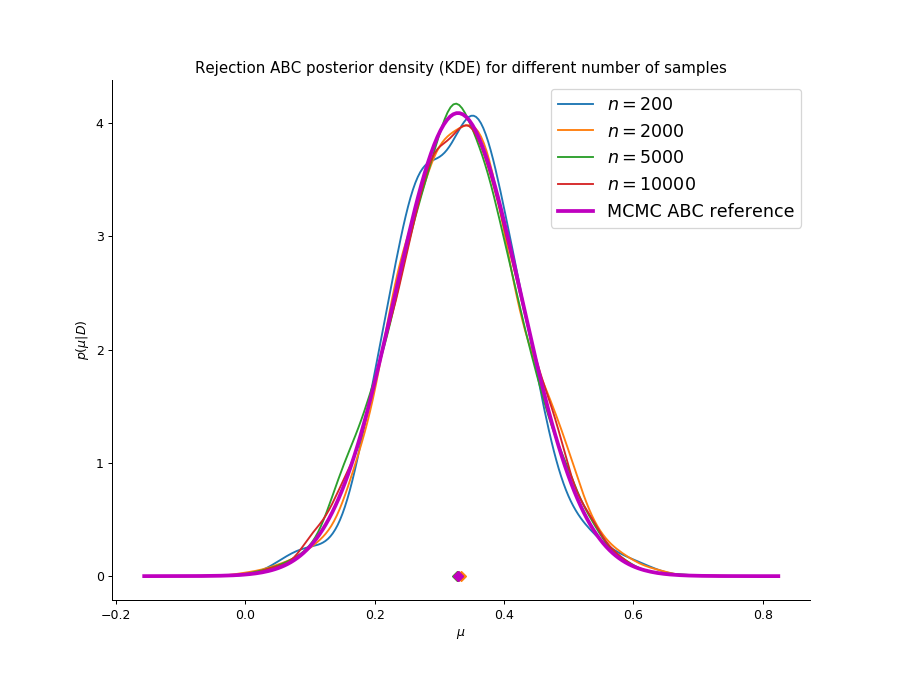

posterior mean: 0.3289307819792879 with error 8.473563788442755e-13


[0.0060886691156665802,
 0.0044946373119241056,
 0.0021144781395241122,
 0.001703671276665522]

In [27]:
rej_200 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_200_0_02_N_100.pkl"))
rej_2000 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_2000_0_02_N_100.pkl"))
rej_5000 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_5000_0_02_N_100.pkl"))
rej_10000 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex01", "rej_10000_0_02_N_100.pkl"))

legend = [r"$n=200$", r"$n=2000$", r"$n=5000$", r"$n=10000$"]

plot_for_report(
    list_of_sampler=[rej_200, rej_2000, rej_5000, rej_10000], 
    posterior=posterior, 
    legend_text=legend, 
    title_text="Rejection ABC posterior density (KDE) for different number of samples", 
    xlabel=r"$\mu$", 
    ylabel=r"$p(\mu|D)$",
    savefig=True,
    figname="ex01_rej_with_diff_samples.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True
)


In [205]:
abs(x_mean - rej_200.Thetas.mean())

0.00044872133199896913

In [206]:
abs(x_mean - rej_2000.Thetas.mean())

0.0042199522617667462

In [207]:
abs(x_mean - rej_5000.Thetas.mean())

0.0020172378338214059

In [208]:
abs(x_mean - rej_10000.Thetas.mean())

0.00059207938993555143

In [28]:
import pandas as pd
df = pd.DataFrame({'samples': [200, 2000, 5000, 10000], 'iterations': [8e3, 79e3, 188e3, 381e3], 'KL': [0.0060886691156665802,
 0.0044946373119241056,
 0.0021144781395241122,
 0.001703671276665522]})

<IPython.core.display.Javascript object>


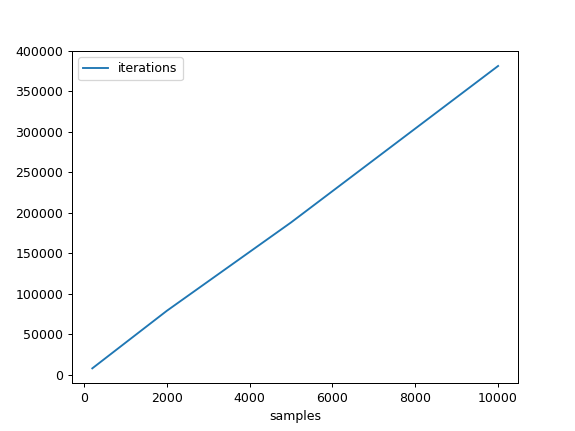

<IPython.core.display.Javascript object>


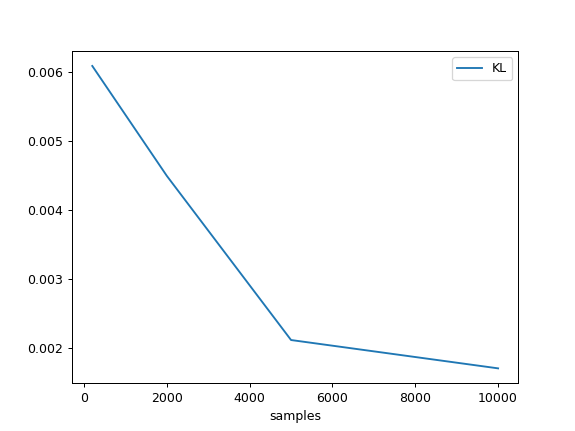

In [29]:
df.plot(x='samples', y='iterations')
df.plot(x='samples', y='KL')